In [1]:
!python --version

Python 3.9.7


In [2]:
!nvidia-smi

Mon Nov  7 18:39:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P40           On   | 00000000:01:00.0 Off |                    0 |
| N/A   30C    P0    47W / 250W |   3960MiB / 23040MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# utils

## masking

In [3]:
import torch

class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask

class ProbMask():
    def __init__(self, B, H, L, index, scores, device="cpu"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                             torch.arange(H)[None, :, None],
                             index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)
    
    @property
    def mask(self):
        return self._mask

## metrics

In [4]:
import numpy as np

def RSE(pred, true):
    return np.sqrt(np.sum((true-pred)**2)) / np.sqrt(np.sum((true-true.mean())**2))

def CORR(pred, true):
    u = ((true-true.mean(0))*(pred-pred.mean(0))).sum(0) 
    d = np.sqrt(((true-true.mean(0))**2*(pred-pred.mean(0))**2).sum(0))
    return (u/d).mean(-1)

def MAE(pred, true):
    return np.mean(np.abs(pred-true))

def MSE(pred, true):
    return np.mean((pred-true)**2)

def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))

def SMAPE(pred, true):
    return np.mean(np.abs(pred - true) / (np.abs(pred) + np.abs(true)/2))

def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    smape = SMAPE(pred, true)
    
    return mae,mse,rmse,mape,mspe,smape

## timefeatures

In [5]:
from typing import List

import numpy as np
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset

class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"

class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5

class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5

class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5

class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5

class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5

class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5

class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5

class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.week - 1) / 52.0 - 0.5

def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)

def time_features(dates, timeenc=1, freq='h'):
    """
    > `time_features` takes in a `dates` dataframe with a 'dates' column and extracts the date down to `freq` where freq can be any of the following if `timeenc` is 0: 
    > * m - [month]
    > * w - [month]
    > * d - [month, day, weekday]
    > * b - [month, day, weekday]
    > * h - [month, day, weekday, hour]
    > * t - [month, day, weekday, hour, *minute]
    > 
    > If `timeenc` is 1, a similar, but different list of `freq` values are supported (all encoded between [-0.5 and 0.5]): 
    > * Q - [month]
    > * M - [month]
    > * W - [Day of month, week of year]
    > * D - [Day of week, day of month, day of year]
    > * B - [Day of week, day of month, day of year]
    > * H - [Hour of day, day of week, day of month, day of year]
    > * T - [Minute of hour*, hour of day, day of week, day of month, day of year]
    > * S - [Second of minute, minute of hour, hour of day, day of week, day of month, day of year]

    *minute returns a number from 0-3 corresponding to the 15 minute period it falls into.
    """
    if timeenc==0:
        dates['month'] = dates.date.apply(lambda row:row.month,1)
        dates['day'] = dates.date.apply(lambda row:row.day,1)
        dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
        dates['hour'] = dates.date.apply(lambda row:row.hour,1)
        dates['minute'] = dates.date.apply(lambda row:row.minute,1)
        dates['minute'] = dates.minute.map(lambda x:x//15)
        freq_map = {
            'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
            'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
            't':['month','day','weekday','hour','minute'],
        }
        return dates[freq_map[freq.lower()]].values
    if timeenc==1:
        dates = pd.to_datetime(dates.date.values)
        return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)]).transpose(1,0)


## tools

In [6]:
import numpy as np
import torch

def adjust_learning_rate(optimizer, epoch, args):
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    if args.lradj=='type1':
        lr_adjust = {epoch: args.learning_rate * (0.5 ** ((epoch-1) // 1))}
    elif args.lradj=='type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6, 
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path+'/'+'checkpoint.pth')
        self.val_loss_min = val_loss

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        if data.shape[-1] != mean.shape[-1]:
            mean = mean[-1:]
            std = std[-1:]
        return (data * std) + mean

# models

## atten.py

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from math import sqrt

class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)
        
    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1./sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)
        
        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)

class ProbAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(ProbAttention, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def _prob_QK(self, Q, K, sample_k, n_top): # n_top: c*ln(L_q)
        # Q [B, H, L, D]
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape

        # calculate the sampled Q_K
        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)
        index_sample = torch.randint(L_K, (L_Q, sample_k)) # real U = U_part(factor*ln(L_k))*L_q
        K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]
        Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze(-2)

        # find the Top_k query with sparisty measurement
        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
        M_top = M.topk(n_top, sorted=False)[1]

        # use the reduced Q to calculate Q_K
        Q_reduce = Q[torch.arange(B)[:, None, None],
                     torch.arange(H)[None, :, None],
                     M_top, :] # factor*ln(L_q)
        Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1)) # factor*ln(L_q)*L_k

        return Q_K, M_top

    def _get_initial_context(self, V, L_Q):
        B, H, L_V, D = V.shape
        if not self.mask_flag:
            # V_sum = V.sum(dim=-2)
            V_sum = V.mean(dim=-2)
            contex = V_sum.unsqueeze(-2).expand(B, H, L_Q, V_sum.shape[-1]).clone()
        else: # use mask
            assert(L_Q == L_V) # requires that L_Q == L_V, i.e. for self-attention only
            contex = V.cumsum(dim=-2)
        return contex

    def _update_context(self, context_in, V, scores, index, L_Q, attn_mask):
        B, H, L_V, D = V.shape

        if self.mask_flag:
            attn_mask = ProbMask(B, H, L_Q, index, scores, device=V.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)

        attn = torch.softmax(scores, dim=-1) # nn.Softmax(dim=-1)(scores)

        context_in[torch.arange(B)[:, None, None],
                   torch.arange(H)[None, :, None],
                   index, :] = torch.matmul(attn, V).type_as(context_in)
        if self.output_attention:
            attns = (torch.ones([B, H, L_V, L_V])/L_V).type_as(attn).to(attn.device)
            attns[torch.arange(B)[:, None, None], torch.arange(H)[None, :, None], index, :] = attn
            return (context_in, attns)
        else:
            return (context_in, None)

    def forward(self, queries, keys, values, attn_mask):
        B, L_Q, H, D = queries.shape
        _, L_K, _, _ = keys.shape

        queries = queries.transpose(2,1)
        keys = keys.transpose(2,1)
        values = values.transpose(2,1)

        U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item() # c*ln(L_k)
        u = self.factor * np.ceil(np.log(L_Q)).astype('int').item() # c*ln(L_q) 

        U_part = U_part if U_part<L_K else L_K
        u = u if u<L_Q else L_Q
        
        scores_top, index = self._prob_QK(queries, keys, sample_k=U_part, n_top=u) 

        # add scale factor
        scale = self.scale or 1./sqrt(D)
        if scale is not None:
            scores_top = scores_top * scale
        # get the context
        context = self._get_initial_context(values, L_Q)
        # update the context with selected top_k queries
        context, attn = self._update_context(context, values, scores_top, index, L_Q, attn_mask)
        
        return context.transpose(2,1).contiguous(), attn


class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, 
                 d_keys=None, d_values=None, mix=False):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model//n_heads)
        d_values = d_values or (d_model//n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads
        self.mix = mix

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask
        )
        if self.mix:
            out = out.transpose(2,1).contiguous()
        out = out.view(B, L, -1)

        return self.out_projection(out), attn


## decoder

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4*d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])

        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1,1))))
        y = self.dropout(self.conv2(y).transpose(-1,1))

        return self.norm3(x+y)

class Decoder(nn.Module):
    def __init__(self, layers, norm_layer=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)

        if self.norm is not None:
            x = self.norm(x)

        return x

## embed

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]

class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model, 
                                    kernel_size=3, padding=padding, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        return x

class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()

class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4; hour_size = 24
        weekday_size = 7; day_size = 32; month_size = 13

        Embed = FixedEmbedding if embed_type=='fixed' else nn.Embedding
        if freq=='t':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)
    
    def forward(self, x):
        x = x.long()
        
        minute_x = self.minute_embed(x[:,:,4]) if hasattr(self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:,:,3])
        weekday_x = self.weekday_embed(x[:,:,2])
        day_x = self.day_embed(x[:,:,1])
        month_x = self.month_embed(x[:,:,0])
        
        return hour_x + weekday_x + day_x + month_x + minute_x

class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h':4, 't':5, 's':6, 'm':1, 'a':1, 'w':2, 'd':3, 'b':3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model)
    
    def forward(self, x):
        return self.embed(x)

class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type, freq=freq) if embed_type!='timeF' else TimeFeatureEmbedding(d_model=d_model, embed_type=embed_type, freq=freq)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.position_embedding(x) + self.temporal_embedding(x_mark)
        
        return self.dropout(x)

## encoder

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvLayer(nn.Module):
    def __init__(self, c_in):
        super(ConvLayer, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.downConv = nn.Conv1d(in_channels=c_in,
                                  out_channels=c_in,
                                  kernel_size=3,
                                  padding=padding,
                                  padding_mode='circular')
        self.norm = nn.BatchNorm1d(c_in)
        self.activation = nn.ELU()
        self.maxPool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.downConv(x.permute(0, 2, 1))
        x = self.norm(x)
        x = self.activation(x)
        x = self.maxPool(x)
        x = x.transpose(1,2)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4*d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        # x = x + self.dropout(self.attention(
        #     x, x, x,
        #     attn_mask = attn_mask
        # ))
        new_x, attn = self.attention(
            x, x, x,
            attn_mask = attn_mask
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1,1))))
        y = self.dropout(self.conv2(y).transpose(-1,1))

        return self.norm2(x+y), attn

class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, attn_mask=attn_mask)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns

class EncoderStack(nn.Module):
    def __init__(self, encoders, inp_lens):
        super(EncoderStack, self).__init__()
        self.encoders = nn.ModuleList(encoders)
        self.inp_lens = inp_lens

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        x_stack = []; attns = []
        for i_len, encoder in zip(self.inp_lens, self.encoders):
            inp_len = x.shape[1]//(2**i_len)
            x_s, attn = encoder(x[:, -inp_len:, :])
            x_stack.append(x_s); attns.append(attn)
        x_stack = torch.cat(x_stack, -2)
        
        return x_stack, attns


## model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# from utils.masking import TriangularCausalMask, ProbMask
# from models.encoder import Encoder, EncoderLayer, ConvLayer, EncoderStack
# from models.decoder import Decoder, DecoderLayer
# from models.attn import FullAttention, ProbAttention, AttentionLayer
# from models.embed import DataEmbedding

class Informer(nn.Module):
    def __init__(self, enc_in, dec_in, c_out, seq_len, label_len, out_len, 
                factor=5, d_model=512, n_heads=8, e_layers=3, d_layers=2, d_ff=512, 
                dropout=0.0, attn='prob', embed='fixed', freq='h', activation='gelu', 
                output_attention = False, distil=True, mix=True,
                device=torch.device('cuda:0')):
        super(Informer, self).__init__()
        self.pred_len = out_len
        self.attn = attn
        self.output_attention = output_attention

        # Encoding
        self.enc_embedding = DataEmbedding(enc_in, d_model, embed, freq, dropout)
        self.dec_embedding = DataEmbedding(dec_in, d_model, embed, freq, dropout)
        # Attention
        Attn = ProbAttention if attn=='prob' else FullAttention
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(Attn(False, factor, attention_dropout=dropout, output_attention=output_attention), 
                                d_model, n_heads, mix=False),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            [
                ConvLayer(
                    d_model
                ) for l in range(e_layers-1)
            ] if distil else None,
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(Attn(True, factor, attention_dropout=dropout, output_attention=False), 
                                d_model, n_heads, mix=mix),
                    AttentionLayer(FullAttention(False, factor, attention_dropout=dropout, output_attention=False), 
                                d_model, n_heads, mix=False),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation,
                )
                for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # self.end_conv1 = nn.Conv1d(in_channels=label_len+out_len, out_channels=out_len, kernel_size=1, bias=True)
        # self.end_conv2 = nn.Conv1d(in_channels=d_model, out_channels=c_out, kernel_size=1, bias=True)
        self.projection = nn.Linear(d_model, c_out, bias=True)
        
    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, 
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)

        dec_out = self.dec_embedding(x_dec, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask)
        dec_out = self.projection(dec_out)
        
        # dec_out = self.end_conv1(dec_out)
        # dec_out = self.end_conv2(dec_out.transpose(2,1)).transpose(1,2)
        if self.output_attention:
            return dec_out[:,-self.pred_len:,:], attns
        else:
            return dec_out[:,-self.pred_len:,:] # [B, L, D]


class InformerStack(nn.Module):
    def __init__(self, enc_in, dec_in, c_out, seq_len, label_len, out_len, 
                factor=5, d_model=512, n_heads=8, e_layers=[3,2,1], d_layers=2, d_ff=512, 
                dropout=0.0, attn='prob', embed='fixed', freq='h', activation='gelu',
                output_attention = False, distil=True, mix=True,
                device=torch.device('cuda:0')):
        super(InformerStack, self).__init__()
        self.pred_len = out_len
        self.attn = attn
        self.output_attention = output_attention

        # Encoding
        self.enc_embedding = DataEmbedding(enc_in, d_model, embed, freq, dropout)
        self.dec_embedding = DataEmbedding(dec_in, d_model, embed, freq, dropout)
        # Attention
        Attn = ProbAttention if attn=='prob' else FullAttention
        # Encoder

        inp_lens = list(range(len(e_layers))) # [0,1,2,...] you can customize here
        encoders = [
            Encoder(
                [
                    EncoderLayer(
                        AttentionLayer(Attn(False, factor, attention_dropout=dropout, output_attention=output_attention), 
                                    d_model, n_heads, mix=False),
                        d_model,
                        d_ff,
                        dropout=dropout,
                        activation=activation
                    ) for l in range(el)
                ],
                [
                    ConvLayer(
                        d_model
                    ) for l in range(el-1)
                ] if distil else None,
                norm_layer=torch.nn.LayerNorm(d_model)
            ) for el in e_layers]
        self.encoder = EncoderStack(encoders, inp_lens)
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(Attn(True, factor, attention_dropout=dropout, output_attention=False), 
                                d_model, n_heads, mix=mix),
                    AttentionLayer(FullAttention(False, factor, attention_dropout=dropout, output_attention=False), 
                                d_model, n_heads, mix=False),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation,
                )
                for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # self.end_conv1 = nn.Conv1d(in_channels=label_len+out_len, out_channels=out_len, kernel_size=1, bias=True)
        # self.end_conv2 = nn.Conv1d(in_channels=d_model, out_channels=c_out, kernel_size=1, bias=True)
        self.projection = nn.Linear(d_model, c_out, bias=True)
        
    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, 
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)

        dec_out = self.dec_embedding(x_dec, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask)
        dec_out = self.projection(dec_out)
        
        # dec_out = self.end_conv1(dec_out)
        # dec_out = self.end_conv2(dec_out.transpose(2,1)).transpose(1,2)
        if self.output_attention:
            return dec_out[:,-self.pred_len:,:], attns
        else:
            return dec_out[:,-self.pred_len:,:] # [B, L, D]


# data

## data_loader

In [12]:
import os
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import StandardScaler

# from utils.tools import StandardScaler
# from utils.timefeatures import time_features

import warnings
warnings.filterwarnings('ignore')

class Dataset_ETT_hour(Dataset):
    def __init__(self, root_path, flag='train', size=None, 
                 features='S', data_path='ETTh1.csv', 
                 target='OT', scale=True, inverse=False, timeenc=0, freq='h', cols=None):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24*4*4
            self.label_len = 24*4
            self.pred_len = 24*4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train':0, 'val':1, 'test':2}
        self.set_type = type_map[flag]
        
        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12*30*24 - self.seq_len, 12*30*24+4*30*24 - self.seq_len]
        border2s = [12*30*24, 12*30*24+4*30*24, 12*30*24+8*30*24]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]
        
        if self.features=='M' or self.features=='MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features=='S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        data_stamp = time_features(df_stamp, timeenc=self.timeenc, freq=self.freq)

        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len 
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        if self.inverse:
            seq_y = np.concatenate([self.data_x[r_begin:r_begin+self.label_len], self.data_y[r_begin+self.label_len:r_end]], 0)
        else:
            seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

class Dataset_ETT_minute(Dataset):
    def __init__(self, root_path, flag='train', size=None, 
                 features='S', data_path='ETTm1.csv', 
                 target='OT', scale=True, inverse=False, timeenc=0, freq='t', cols=None):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24*4*4
            self.label_len = 24*4
            self.pred_len = 24*4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train':0, 'val':1, 'test':2}
        self.set_type = type_map[flag]
        
        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12*30*24*4 - self.seq_len, 12*30*24*4+4*30*24*4 - self.seq_len]
        border2s = [12*30*24*4, 12*30*24*4+4*30*24*4, 12*30*24*4+8*30*24*4]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]
        
        if self.features=='M' or self.features=='MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features=='S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        data_stamp = time_features(df_stamp, timeenc=self.timeenc, freq=self.freq)
        
        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        if self.inverse:
            seq_y = np.concatenate([self.data_x[r_begin:r_begin+self.label_len], self.data_y[r_begin+self.label_len:r_end]], 0)
        else:
            seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_Custom(Dataset):
    def __init__(self, root_path, flag='train', size=None, 
                 features='S', data_path='ETTh1.csv', 
                 target='OT', scale=True, inverse=False, timeenc=0, freq='h', cols=None):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24*4*4
            self.label_len = 24*4
            self.pred_len = 24*4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train':0, 'val':1, 'test':2}
        self.set_type = type_map[flag]
        
        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        self.cols=cols
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))
        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        # cols = list(df_raw.columns); 
        if self.cols:
            cols=self.cols.copy()
            cols.remove(self.target)
        else:
            cols = list(df_raw.columns); cols.remove(self.target); cols.remove('date')
        df_raw = df_raw[['date']+cols+[self.target]]

        num_train = int(len(df_raw)*0.6)
        num_test = int(len(df_raw)*0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train-self.seq_len, len(df_raw)-num_test-self.seq_len]
        border2s = [num_train, num_train+num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]
        
        if self.features=='M' or self.features=='MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features=='S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        data_stamp = time_features(df_stamp, timeenc=self.timeenc, freq=self.freq)

        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len 
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        if self.inverse:
            seq_y = np.concatenate([self.data_x[r_begin:r_begin+self.label_len], self.data_y[r_begin+self.label_len:r_end]], 0)
        else:
            seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

class Dataset_Pred(Dataset):
    def __init__(self, root_path, flag='pred', size=None, 
                 features='S', data_path='ETTh1.csv', 
                 target='OT', scale=True, inverse=False, timeenc=0, freq='15min', cols=None):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24*4*4
            self.label_len = 24*4
            self.pred_len = 24*4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['pred']
        
        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        self.cols=cols
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))
        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        if self.cols:
            cols=self.cols.copy()
            cols.remove(self.target)
        else:
            cols = list(df_raw.columns); cols.remove(self.target); cols.remove('date')
        df_raw = df_raw[['date']+cols+[self.target]]
        print(len(df_raw))
        print(self.seq_len)
        
        border1 = len(df_raw)-self.seq_len
        border2 = len(df_raw)
        
        if self.features=='M' or self.features=='MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features=='S':
            df_data = df_raw[[self.target]]

        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
        print(pred_dates)
        
        df_stamp = pd.DataFrame(columns = ['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        data_stamp = time_features(df_stamp, timeenc=self.timeenc, freq=self.freq[-1:])

        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        if self.inverse:
            seq_y = self.data_x[r_begin:r_begin+self.label_len]
        else:
            seq_y = self.data_y[r_begin:r_begin+self.label_len]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def __len__(self):
        return len(self.data_x) - self.seq_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


# exp

## exp_basic

In [13]:
import os
import torch
import numpy as np

class Exp_Basic(object):
    def __init__(self, args):
        self.args = args
        self.device = self._acquire_device()
        self.model = self._build_model().to(self.device)

    def _build_model(self):
        raise NotImplementedError
        return None
    
    def _acquire_device(self):
        if self.args.use_gpu:
            os.environ["CUDA_VISIBLE_DEVICES"] = str(self.args.gpu) if not self.args.use_multi_gpu else self.args.devices
            device = torch.device('cuda:{}'.format(self.args.gpu))
            print('Use GPU: cuda:{}'.format(self.args.gpu))
        else:
            device = torch.device('cpu')
            print('Use CPU')
        return device

    def _get_data(self):
        pass

    def vali(self):
        pass

    def train(self):
        pass

    def test(self):
        pass
    

## exp_informer

In [14]:
from torch import optim
from torch.utils.data import DataLoader
import time

import warnings
warnings.filterwarnings('ignore')

class Exp_Informer(Exp_Basic):
    def __init__(self, args):
        super(Exp_Informer, self).__init__(args)
    
    def _build_model(self):
        model_dict = {
            'informer':Informer,
            'informerstack':InformerStack,
        }
        if self.args.model=='informer' or self.args.model=='informerstack':
            e_layers = self.args.e_layers if self.args.model=='informer' else self.args.s_layers
            model = model_dict[self.args.model](
                self.args.enc_in,
                self.args.dec_in, 
                self.args.c_out, 
                self.args.seq_len, 
                self.args.label_len,
                self.args.pred_len, 
                self.args.factor,
                self.args.d_model, 
                self.args.n_heads, 
                self.args.e_layers, # e_layers,
                self.args.d_layers, 
                self.args.d_ff,
                self.args.dropout, 
                self.args.attn,
                self.args.embed,
                self.args.freq,
                self.args.activation,
                self.args.output_attention,
                self.args.distil,
                self.args.mix,
                self.device
            ).float()
        
        if self.args.use_multi_gpu and self.args.use_gpu:
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
        return model

    def _get_data(self, flag):
        args = self.args

        data_dict = {
            'ETTh1':Dataset_ETT_hour,
            'ETTh2':Dataset_ETT_hour,
            'ETTm1':Dataset_ETT_minute,
            'ETTm2':Dataset_ETT_minute,
            'WTH':Dataset_Custom,
            'ECL':Dataset_Custom,
            'Solar':Dataset_Custom,
            'custom':Dataset_Custom,
        }
        Data = data_dict[self.args.data]
        timeenc = 0 if args.embed!='timeF' else 1

        if flag == 'test':
            shuffle_flag = False; drop_last = True; batch_size = args.batch_size; freq=args.freq
        elif flag=='pred':
            shuffle_flag = False; drop_last = False; batch_size = 1; freq=args.detail_freq
            Data = Dataset_Pred
        else:
            shuffle_flag = True; drop_last = True; batch_size = args.batch_size; freq=args.freq
        data_set = Data(
            root_path=args.root_path,
            data_path=args.data_path,
            flag=flag,
            size=[args.seq_len, args.label_len, args.pred_len],
            features=args.features,
            target=args.target,
            inverse=args.inverse,
            timeenc=timeenc,
            freq=freq,
            cols=args.cols
        )
        print(flag, len(data_set))
        data_loader = DataLoader(
            data_set,
            batch_size=batch_size,
            shuffle=shuffle_flag,
            num_workers=args.num_workers,
            drop_last=drop_last)

        return data_set, data_loader

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim
    
    def _select_criterion(self):
        criterion =  nn.MSELoss()
        return criterion

    def vali(self, vali_data, vali_loader, criterion):
        self.model.eval()
        total_loss = []
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(vali_loader):
            pred, true = self._process_one_batch(
                vali_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
            loss = criterion(pred.detach().cpu(), true.detach().cpu())
            total_loss.append(loss)
        total_loss = np.average(total_loss)
        self.model.train()
        return total_loss

    def train(self, setting):
        train_data, train_loader = self._get_data(flag = 'train')
        vali_data, vali_loader = self._get_data(flag = 'val')
        test_data, test_loader = self._get_data(flag = 'test')

        path = os.path.join(self.args.checkpoints, setting)
        if not os.path.exists(path):
            os.makedirs(path)

        time_now = time.time()
        
        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)
        
        model_optim = self._select_optimizer()
        criterion =  self._select_criterion()

        if self.args.use_amp:
            scaler = torch.cuda.amp.GradScaler()

        for epoch in range(self.args.train_epochs):
            iter_count = 0
            train_loss = []
            
            self.model.train()
            epoch_time = time.time()
            for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_loader):
                iter_count += 1
                
                model_optim.zero_grad()
                pred, true = self._process_one_batch(
                    train_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
                loss = criterion(pred, true)
                train_loss.append(loss.item())
                
                if (i+1) % 100==0:
                    print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                    speed = (time.time()-time_now)/iter_count
                    left_time = speed*((self.args.train_epochs - epoch)*train_steps - i)
                    print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                    iter_count = 0
                    time_now = time.time()
                
                if self.args.use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(model_optim)
                    scaler.update()
                else:
                    loss.backward()
                    model_optim.step()

            print("Epoch: {} cost time: {}".format(epoch+1, time.time()-epoch_time))
            train_loss = np.average(train_loss)
            vali_loss = self.vali(vali_data, vali_loader, criterion)
            test_loss = self.vali(test_data, test_loader, criterion)

            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
                epoch + 1, train_steps, train_loss, vali_loss, test_loss))
            early_stopping(vali_loss, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            adjust_learning_rate(model_optim, epoch+1, self.args)
            
        best_model_path = path+'/'+'checkpoint.pth'
        self.model.load_state_dict(torch.load(best_model_path))
        
        return self.model

    def test(self, setting):
        test_data, test_loader = self._get_data(flag='test')
        
        self.model.eval()
        
        preds = []
        trues = []
        
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
            pred, true = self._process_one_batch(
                test_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
            preds.append(pred.detach().cpu().numpy())
            trues.append(true.detach().cpu().numpy())

        preds = np.array(preds)
        trues = np.array(trues)
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)

        # result save
        folder_path = './results/' + setting +'/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        mae, mse, rmse, mape, mspe, smape = metric(preds, trues)
        print('mse:{}, mae:{}, smape:{}'.format(mse, mae, smape))

        np.save(folder_path+'metrics.npy', np.array([mae, mse, rmse, mape, mspe, smape]))
        np.save(folder_path+'pred.npy', preds)
        np.save(folder_path+'true.npy', trues)

        return

    def predict(self, setting, load=False):
        pred_data, pred_loader = self._get_data(flag='pred')
        
        if load:
            path = os.path.join(self.args.checkpoints, setting)
            best_model_path = path+'/'+'checkpoint.pth'
            self.model.load_state_dict(torch.load(best_model_path))

        self.model.eval()
        
        preds = []
        
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
            pred, true = self._process_one_batch(
                pred_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
            preds.append(pred.detach().cpu().numpy())

        preds = np.array(preds)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        
        # result save
        folder_path = './results/' + setting +'/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        np.save(folder_path+'real_prediction.npy', preds)
        
        return

    def _process_one_batch(self, dataset_object, batch_x, batch_y, batch_x_mark, batch_y_mark):
        batch_x = batch_x.float().to(self.device)
        batch_y = batch_y.float()

        batch_x_mark = batch_x_mark.float().to(self.device)
        batch_y_mark = batch_y_mark.float().to(self.device)

        # decoder input
        if self.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], self.args.pred_len, batch_y.shape[-1]]).float()
        elif self.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], self.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:self.args.label_len,:], dec_inp], dim=1).float().to(self.device)
        # encoder - decoder
        if self.args.use_amp:
            with torch.cuda.amp.autocast():
                if self.args.output_attention:
                    outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if self.args.output_attention:
                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        if self.args.inverse:
            outputs = dataset_object.inverse_transform(outputs)
        f_dim = -1 if self.args.features=='MS' else 0
        batch_y = batch_y[:,-self.args.pred_len:,f_dim:].to(self.device)

        return outputs, batch_y


# Informer2020

In [15]:
# #--------------------------------#
import pandas as pd
# # move price to the last column

# import pandas as pd
# bac_full_with_sentiment = pd.read_csv('/home/sean/5703/informer/data/bac_full_with_sentiment.csv')
# cols = list(bac_full_with_sentiment.columns.values)
# cols.pop(cols.index('close'))
# bac_full_with_sentiment = bac_full_with_sentiment[cols+['close']]
# bac_full_with_sentiment.to_csv('/home/sean/5703/informer/data/bac_full_with_sentiment.csv', index=False)


## code

In [16]:
# import pandas as pd
# pf = pd.read_csv('../../../../5703/dataset/finbert_likes_sum_final.csv')
# pf

In [17]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '../../dataset/bac/8combinations'
args.data_path = 'final_news_vader_sum.csv'
args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'close'
args.freq = 'b'
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 270 # input sequence length of Informer encoder
args.label_len = 7 # start token length of Informer decoder
args.pred_len = 14 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

#----------------------------------------#
# number of columns in data minus 1
args.enc_in = 8 # encoder input size
args.dec_in = 8 # decoder input size
args.c_out = 1 # output size
#----------------------------------------#

args.factor = 5 # probsparse attn factor
args.d_model = 1024 # dimension of model
args.n_heads = 64 # num of heads
args.e_layers = 2 #[3,2,1] # num of encoder layers if informerstack
args.d_layers = 1 # num of decoder layers
args.d_ff = 512 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'full' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'b'
# args.inverse = True

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 12
args.patience = 4
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [18]:
Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [19]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

args.detail_freq = args.freq
args.freq = args.freq[-1:]

print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'custom', 'root_path': '../../dataset/bac/8combinations', 'data_path': 'final_news_vader_sum.csv', 'features': 'MS', 'target': 'close', 'freq': 'b', 'checkpoints': './informer_checkpoints', 'seq_len': 270, 'label_len': 7, 'pred_len': 14, 'enc_in': 8, 'dec_in': 8, 'c_out': 1, 'factor': 5, 'd_model': 1024, 'n_heads': 64, 'e_layers': 2, 'd_layers': 1, 'd_ff': 512, 'dropout': 0.05, 'attn': 'full', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 12, 'patience': 4, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'b'}


In [20]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(666)

In [21]:
Exp = Exp_Informer
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftMS_sl270_ll7_pl14_dm1024_nh64_el2_dl1_df512_atfull_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 774
val 340
test 339
Epoch: 1 cost time: 5.8814475536346436
Epoch: 1, Steps: 24 | Train Loss: 0.3922235 Vali Loss: 0.0804270 Test Loss: 0.1959424
Validation loss decreased (inf --> 0.080427).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 5.2799859046936035
Epoch: 2, Steps: 24 | Train Loss: 0.0792503 Vali Loss: 0.0685337 Test Loss: 0.1674242
Validation loss decreased (0.080427 --> 0.068534).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 5.281288385391235
Epoch: 3, Steps: 24 | Train Loss: 0.0525534 Vali Loss: 0.0676912 Test Loss: 0.1584679
Validation loss decreased (0.068534 --> 0.067691).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 5.279569149017334
Epoch: 4, Steps: 24 | Train Loss: 0.0479901 Vali Loss: 0.0667480 Test Loss: 0.1587096
Validat

# Prediction

In [22]:
# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

exp = Exp(args)

exp.predict(setting, True)

Use GPU: cuda:0
1762
270
DatetimeIndex(['2016-12-30', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19'],
              dtype='datetime64[ns]', freq='B')
pred 1


In [23]:
# the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

(1, 14, 1)

In [24]:
prediction


array([[[1.6172967],
        [2.0411055],
        [2.0673916],
        [1.9413316],
        [1.9505795],
        [1.9336001],
        [1.8459368],
        [1.9604871],
        [2.0834715],
        [1.9987123],
        [2.0927598],
        [2.026373 ],
        [2.1573884],
        [1.6501299]]], dtype=float32)

# Visualization

In [25]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((320, 14, 1), (320, 14, 1))

In [26]:
trues[-1,:,-1]

array([2.3936198, 2.4170432, 2.296998 , 2.3936198, 2.3701963, 2.466818 ,
       2.458034 , 2.5341604, 2.6219988, 2.458034 , 2.4551067, 2.6981251,
       2.8093863, 2.7303321], dtype=float32)

In [27]:
preds[-1,:,-1,]

array([1.1827135, 1.4731371, 1.5085108, 1.4239043, 1.3844438, 1.2488481,
       1.2720196, 1.2627871, 1.3067323, 1.272723 , 1.435576 , 1.2562735,
       1.3739161, 1.2971878], dtype=float32)

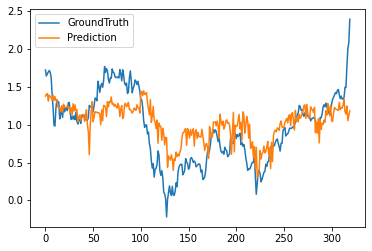

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
plt.plot(trues[:, 0, :], label='GroundTruth')
plt.plot(preds[:, 0, :], label='Prediction')
plt.legend()
plt.show()

In [29]:
def SMAPE(pred, true):
    return np.mean(np.abs(pred - true) / (np.abs(pred) + np.abs(true)/2))

# check which index has the smallest SMAPE
current_smape = np.Infinity
for i in range(14):
    smape = SMAPE(preds[:, i, :], trues[:, i, :])
    if smape < current_smape:
        current_smape = smape
        index = i

print('The index of the smallest SMAPE is: ', index) 

The index of the smallest SMAPE is:  2


1762
270
DatetimeIndex(['2016-12-30', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19'],
              dtype='datetime64[ns]', freq='B')


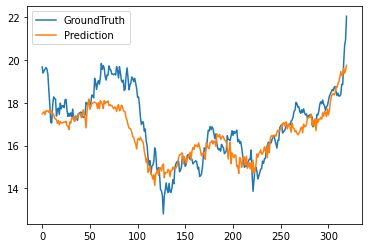

Smape of LSTM:  0.05237561489184284
Smape of Informer:  0.0373226649838036
Smape of Ensemble:  0.029415847105963084


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, 0)
                
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')
flag = 'pred'

if flag=='pred':
            shuffle_flag = False; drop_last = False; batch_size = 1; freq=args.detail_freq
            Data = Dataset_Pred

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

# get the inverse transformed
pred_inver = data_set.inverse_transform(preds)
trues = data_set.inverse_transform(trues)
pred_inver.shape

lstm_preds = np.load('./final_news_vader_sum.npy')
# drop the last 13 sample
lstm_preds = lstm_preds[:-13, :]

informer_preds = pred_inver[:, 0, :]


# average the predictions of Informer and LSTM
ensemble_preds = (lstm_preds + informer_preds) / 2
ensemble_preds.shape

plt.figure()
plt.plot(trues[:, 0, :], label='GroundTruth')
plt.plot(ensemble_preds, label='Prediction')
plt.legend()
plt.show()

print("Smape of LSTM: ", SMAPE(lstm_preds, trues[:, 0, :]))
print("Smape of Informer: ", SMAPE(informer_preds, trues[:, 0, :]))
print("Smape of Ensemble: ", SMAPE(ensemble_preds, trues[:, 0, :]))